In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import decimate
from tsfresh import extract_features
from tsfresh.feature_selection import select_features

In [2]:
class DataProcessor:
    def __init__(self, input_path, file_names):
        self.input_path = input_path
        self.file_names = file_names
        
    def read_files(self):
        self.data = {}
        print("Reading files...")
        for file in self.file_names:
            with open(self.input_path + file + '.txt', 'r') as f:
                self.data[file] = pd.read_csv(f, header=None, sep='\t')
        return self.data
    
    def print_shape(self):
        print("Files read:")
        for file in self.data:
            print(f"{file}: {self.data[file].shape}")
            
    def create_target_df(self):
        target_columns = ['Cooler_Condition', 'Valve_Condition', 
                        'Internal_Pump_Leakage', 'Hydraulic_Accumulator', 
                        'Stable_Flag']
        self.data['target'].columns = target_columns
        self.valve_condition = self.data['target']['Valve_Condition']
        #del self.data['target']
        return self.valve_condition

def process_data():
    input_path = "input_data/"
    file_names = [
        "ce", "cp", "eps1", "se", "vs1", 
        "fs1", "fs2", 
        "ps1", "ps2", "ps3", "ps4", "ps5", "ps6",
        "ts1", "ts2", "ts3", "ts4", "target"
    ]
    
    processor = DataProcessor(input_path, file_names)
    data = processor.read_files()
    processor.print_shape()
    df_target = processor.create_target_df()
    df_target = processor.valve_condition
    return data, df_target

data, df_target = process_data()

Reading files...
Files read:
ce: (2205, 60)
cp: (2205, 60)
eps1: (2205, 6000)
se: (2205, 60)
vs1: (2205, 60)
fs1: (2205, 600)
fs2: (2205, 600)
ps1: (2205, 6000)
ps2: (2205, 6000)
ps3: (2205, 6000)
ps4: (2205, 6000)
ps5: (2205, 6000)
ps6: (2205, 6000)
ts1: (2205, 60)
ts2: (2205, 60)
ts3: (2205, 60)
ts4: (2205, 60)
target: (2205, 5)


In [3]:
df_list = ['se', 'fs1', 'ps3']

df_downsampled = {}

for df in df_list:
    filtered_signals = []  # Reset for each DataFrame
    if data[df].shape[1] == 6000:
        downsample_factor = 100
        for i in range(data[df].shape[0]):
            row = data[df].iloc[i].values  # Extract row as a 1D array
            filtered_signal = decimate(row, downsample_factor, ftype='fir')  # Downsample
            filtered_signals.append(filtered_signal)  # Store the result
        # Create a new DataFrame with the filtered signals and add the 'id' column
        df_downsampled[df] = pd.DataFrame(filtered_signals)
        df_downsampled[df]["id"] = df_downsampled[df].index

    elif data[df].shape[1] == 600:
        downsample_factor = 10
        for i in range(data[df].shape[0]):
            row = data[df].iloc[i].values  # Extract row as a 1D array
            filtered_signal = decimate(row, downsample_factor, ftype='fir')  # Downsample
            filtered_signals.append(filtered_signal)  # Store the result
        # Create a new DataFrame with the filtered signals and add the 'id' column
        df_downsampled[df] = pd.DataFrame(filtered_signals)
        df_downsampled[df]["id"] = df_downsampled[df].index

    else:
        df_downsampled[df] = data[df]
        df_downsampled[df]["id"] = df_downsampled[df].index

# Combine all DataFrames
df_combined = pd.concat([df_downsampled[df] for df in df_list], ignore_index=True)

df_combined

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,id
0,68.039000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.141000,...,68.101000,68.101000,68.420000,68.420000,68.223000,68.223000,68.159000,68.159000,68.264000,0
1,68.264000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.715000,...,68.536000,68.536000,68.465000,68.465000,68.491000,68.491000,68.528000,68.528000,68.595000,1
2,68.595000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.320000,...,68.901000,68.901000,68.805000,68.805000,68.456000,68.456000,68.758000,68.758000,68.628000,2
3,68.628000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.991000,...,68.860000,68.860000,68.946000,68.946000,69.021000,69.021000,68.851000,68.851000,68.868000,3
4,68.868000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.523000,...,68.483000,68.483000,68.819000,68.819000,68.862000,68.862000,69.036000,69.036000,68.972000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6610,0.172926,0.011496,-0.018428,0.024396,-0.043644,0.063811,-0.104500,0.168088,-0.308903,0.980114,...,2.317221,2.344719,2.342248,2.311307,2.359219,2.300111,2.390136,2.225378,2.583649,2200
6611,0.174585,0.011612,-0.018216,0.023935,-0.042724,0.062371,-0.102110,0.162070,-0.301379,0.960469,...,2.351193,2.298340,2.330884,2.312942,2.351669,2.291068,2.402735,2.230432,2.545339,2201
6612,0.170944,0.011664,-0.018810,0.025126,-0.044919,0.065827,-0.107497,0.169427,-0.318937,1.016304,...,2.301769,2.340973,2.351554,2.324610,2.339859,2.286507,2.403170,2.205626,2.521674,2202
6613,0.173025,0.011461,-0.018365,0.024314,-0.043512,0.063590,-0.104051,0.163943,-0.308924,0.981163,...,2.350127,2.354437,2.351759,2.355719,2.375095,2.312541,2.435032,2.259279,2.562707,2203


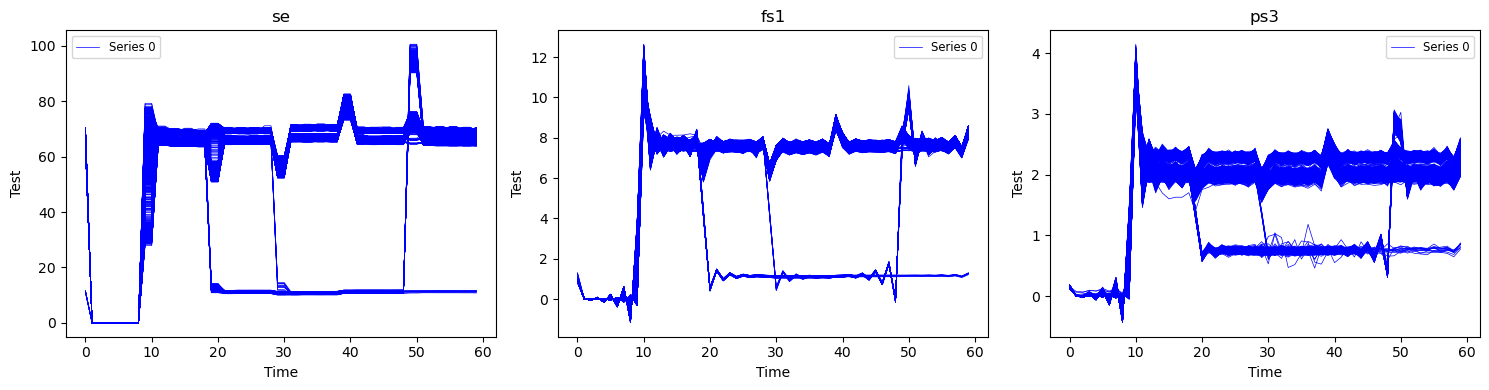

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=100)
axes = axes.flatten()

for idx, s in enumerate(df_list):
    ax = axes[idx]
    df = df_downsampled[s].drop(columns=['id'])  # Adjusted to use `s` and drop the column correctly
    
    for i in range(df.shape[0] - 1):
        ax.plot(df.iloc[i], color='blue', linewidth=0.5, label=f'Series {i}' if i == 0 else "")  # Add label only once
    
    ax.set_title(s)
    ax.set_xlabel("Time")
    ax.set_ylabel("Test")

    ax.legend(loc='best', fontsize='small')  # Legend specific to each subplot

plt.tight_layout()
plt.show()


In [22]:
import pandas as pd

# Fenstergröße und Überlappung festlegen
window_size = 10  # alle 10 Spalten sind ein Fenster
overlap = 0  # 3 Spalten Überlappung

# Entferne 'id' und setze die Zielspalte 'id'
window_df = df_combined.drop(columns=['id'])
id = df_combined["id"]

# Liste für die Fenster
windows = []

# Schleife zur Fenstererstellung mit Überlappung
for start_col in range(0, window_df.shape[1] - window_size + 1, window_size - overlap):
    # Bestimme das Ende des Fensters
    end_col = start_col + window_size
    
    # Wähle das Fenster aus den Daten
    window = window_df.iloc[:, start_col:end_col]
    
    # Füge die 'time'-Spalte hinzu
    window["id"] = id
    
    # Fenster zur Liste hinzufügen
    windows.append(window)

# Ergebnis
print(f"Anzahl der Fenster: {len(windows)}")

# # Optional: Ausgabe eines Fensters zur Kontrolle
# # print(final_df.head())


Anzahl der Fenster: 6


In [28]:
windows_combined = pd.concat([i for i in windows], ignore_index=True)

In [24]:
# Spaltennamen des ersten Fensters extrahieren
reference_columns = windows[0].columns.tolist()

# Angleichung der Spaltennamen aller Fenster an die des ersten Fensters
for i in range(1, len(windows)):
    windows[i].columns = reference_columns

In [29]:
windows_combined

,0,1,2,3,4,5,6,7,8,9,id
0,68.039000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.141000,0
1,68.264000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.715000,1
2,68.595000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.320000,2
3,68.628000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.991000,3
4,68.868000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.523000,4
...,...,...,...,...,...,...,...,...,...,...,...
39685,2.378832,2.317221,2.344719,2.342248,2.311307,2.359219,2.300111,2.390136,2.225378,2.583649,2200
39686,2.400859,2.351193,2.298340,2.330884,2.312942,2.351669,2.291068,2.402735,2.230432,2.545339,2201
39687,2.354210,2.301769,2.340973,2.351554,2.324610,2.339859,2.286507,2.403170,2.205626,2.521674,2202
39688,2.393996,2.350127,2.354437,2.351759,2.355719,2.375095,2.312541,2.435032,2.259279,2.562707,2203


In [30]:
window_long = pd.melt(windows_combined, id_vars=['id'], var_name='time', value_name='value')

In [31]:
window_long

,id,time,value
0,0,0,68.039000
1,1,0,68.264000
2,2,0,68.595000
3,3,0,68.628000
4,4,0,68.868000
...,...,...,...
396895,2200,9,2.583649
396896,2201,9,2.545339
396897,2202,9,2.521674
396898,2203,9,2.562707


In [32]:
extracted_features = extract_features(window_long, 
                                        column_id="id", 
                                        column_sort="time")

Feature Extraction: 100%|██████████| 30/30 [01:49<00:00,  3.65s/it]


In [33]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df_target)

In [19]:
features

'v'

In [34]:
# clean the features
extracted_features = extracted_features.dropna(axis=1)
extracted_features.replace([np.inf, -np.inf], np.nan, inplace=True)
extracted_features = extracted_features.dropna(how = "all", axis= "columns")
# Feature-Selektion basierend auf Zielwerten
extracted_features = select_features(extracted_features, y=y_encoded)
selector = VarianceThreshold()
extracted_features = selector.fit_transform(extracted_features)

In [35]:
# check shape of feature and target
if extracted_features.shape[0] == y_encoded.shape[0]:
    print("Data is ready for Modelling!")
    print(f"Shape features: {extracted_features.shape}")
    print(f"Shape target: {y_encoded.shape}")
else:
    print("Shape of the Inputs and target don't match. Please check preprocesing steps")

Data is ready for Modelling!
Shape features: (2205, 677)
Shape target: (2205,)


In [36]:
states = [27, 6728, 49122]
accs = []
features = extracted_features
target = y_encoded

In [37]:
for RANDOM_STATE in states:
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size = 0.2, random_state = RANDOM_STATE, stratify = target
    )
    
    model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=30
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accs.append(accuracy_score(y_test, preds))
    print(f"Random State: {RANDOM_STATE}")
    print(classification_report(y_test, preds, zero_division=0.0))

accs_mean = round(np.mean(accs), 4)
accs_std = round(np.std(accs), 4)

print(f"Mean Accuracy: {accs_mean}")
print(f"Std Accuracy: {accs_std}")

c:\Users\Daniel\anaconda3\envs\py_adv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Random State: 27
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        72
           1       0.97      1.00      0.99        72
           2       0.75      0.89      0.82        72
           3       0.96      0.91      0.93       225

    accuracy                           0.93       441
   macro avg       0.92      0.94      0.93       441
weighted avg       0.94      0.93      0.93       441



c:\Users\Daniel\anaconda3\envs\py_adv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Random State: 6728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       0.99      1.00      0.99        72
           2       0.71      0.82      0.76        72
           3       0.94      0.89      0.92       225

    accuracy                           0.92       441
   macro avg       0.91      0.93      0.92       441
weighted avg       0.92      0.92      0.92       441



c:\Users\Daniel\anaconda3\envs\py_adv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Random State: 49122
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.97      0.99        72
           2       0.80      0.99      0.88        72
           3       1.00      0.92      0.96       225

    accuracy                           0.95       441
   macro avg       0.94      0.97      0.95       441
weighted avg       0.96      0.95      0.95       441

Mean Accuracy: 0.9327
Std Accuracy: 0.015


In [38]:
for RANDOM_STATE in states:
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size = 0.2, random_state = RANDOM_STATE, stratify = target
    )
    
    clf = svm.SVC(kernel='linear')
    
    clf.fit(X_train, y_train)
    preds = model.predict(X_test)
    accs.append(accuracy_score(y_test, preds))
    print(f"Random State: {RANDOM_STATE}")
    print(classification_report(y_test, preds, zero_division=0.0))

accs_mean = round(np.mean(accs), 4)
accs_std = round(np.std(accs), 4)

print(f"Mean Accuracy: {accs_mean}")
print(f"Std Accuracy: {accs_std}")

Random State: 27
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        72
           2       0.76      0.96      0.85        72
           3       0.99      0.90      0.94       225

    accuracy                           0.94       441
   macro avg       0.94      0.97      0.95       441
weighted avg       0.95      0.94      0.95       441

Random State: 6728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        72
           2       0.76      0.94      0.84        72
           3       0.98      0.91      0.94       225

    accuracy                           0.94       441
   macro avg       0.94      0.96      0.95       441
weighted avg       0.95      0.94      0.95       441

Random State: 49122
              precision    recall  f1-score   support

           0       

In [39]:
for RANDOM_STATE in states:
 
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=RANDOM_STATE, stratify=target
    )
    
    # Standardise features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    
    preds = knn.predict(X_test)  # Korrigiert von `model.predict` zu `knn.predict`
    accs.append(accuracy_score(y_test, preds))
    
    # Ergebnisse ausgeben
    print(f"Random State: {RANDOM_STATE}")
    print(classification_report(y_test, preds, zero_division=0.0))


accs_mean = round(np.mean(accs), 4)
accs_std = round(np.std(accs), 4)

print(f"Mean Accuracy: {accs_mean}")
print(f"Std Accuracy: {accs_std}")

Random State: 27
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       0.99      1.00      0.99        72
           2       0.72      0.69      0.71        72
           3       0.91      0.92      0.91       225

    accuracy                           0.91       441
   macro avg       0.90      0.90      0.90       441
weighted avg       0.91      0.91      0.91       441

Random State: 6728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       0.99      1.00      0.99        72
           2       0.72      0.58      0.65        72
           3       0.87      0.92      0.90       225

    accuracy                           0.89       441
   macro avg       0.90      0.88      0.88       441
weighted avg       0.89      0.89      0.89       441

Random State: 49122
              precision    recall  f1-score   support

           0       